In [12]:
# ======================================================================================
# Notebook setup
# 
# Run this cell before all others to make sure that the Jupyter notebook works properly
# ======================================================================================

# Automatically reload all imported modules
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, accuracy_score
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from keras.layers import Dense

figsize = (20, 4.5)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Deep Learning

## Deep Networks

**In the last lecture we have mentioned that:**

<center>
<img src="assets/ann.png" width=60%/>
</center>

* A NN with more than one hidden layer is called _deep_
* Deep networks can encode _more complex relations_ than shallow ones
* I.e. they can have higher variance

**So why has Deep Learning become a thing only in the last decade?**

## Enablers for Deep Learning

**There are three main reasons:**

1) Learning complex relations is viable only with _abundant data_

* With small datasets, high variance models risk overfitting
* ...And for complex relations low-variance models are enough
* Only recently larger data collection have become widely available

2) Handling abundant data may require considerable _computational power_

* Deep nets for many industrial problems are actually not too hard to train
* ...At least with modern hardware
* ...But the "famous" models take up to millions of \$ to train!

3) Historically, there was _no good training algorithm_ for deep nets

* This is worth explaining mode in detail...

## Vanishing Gradient Problem

**A network with $n$ hidden layers can be seen as something like:**

$$
f(x, w) = g(w_{g} \cdot h(w_{n} \cdot  h(w_{n-1} \cdot  h(...)))
$$

* Where $h_k$ is the activation function for $k$-th hidden layer
* And $g$ is the activation function for the output layer.

**When we apply gradient computation to the formula**

...With some abuse of notation we get:

$$
f^\prime(x, w) = g^\prime w_{n}^T h^\prime w_{n-1}^T h^\prime \ldots
$$

* Historically, _sigmoid_ activation functions were used in all hidden layers
* ...And for a sigmoid we have $|h^\prime| < 1$

**Therefore, the more layers we have, the weaker the gradient becomes!**

## Vanishing Gradient Problem

**This problem is now usually solved with a very simple trick**

I.e. by _always using ReLUs_ in the hidden layers

* ReLUs are almost everywhere differentiable
* When they are inactive, their derivative is 0
  - ...Which kill the gradient completely
* ...But when they are active, their derivative is 1
  - ...Which does not dampen the gradient at all!
  
**There are cases when other activation functions are used**

...But there must be a good reason for doing that

* In most cases, sticking to ReLU is fine

## Loading the Data

**We will now see how to use deep networks in practice**

Let's start by loading the housing dataset (again):

In [3]:
data = pd.read_csv('data/real_estate.csv', sep=',')
in_cols = [c for c in data.columns if c != 'price per area']
X = data[in_cols]
y = np.log(data[['price per area']])
X_tr, X_ts, y_tr, y_ts = train_test_split(X, y, test_size=0.34, random_state=42)

data.head()

,house age,dist to MRT,#stores,latitude,longitude,price per area
0,14.8,393.2606,6,24.96172,121.53812,7.6
1,17.4,6488.0210,1,24.95719,121.47353,11.2
2,16.0,4066.5870,0,24.94297,121.50342,11.6
3,30.9,6396.2830,1,24.94375,121.47883,12.2
4,16.5,4082.0150,0,24.94155,121.50381,12.8


* The task is still estimating "price per area"
* It's boring, but it will make for an easier comparison w.r.t. other approaches

## Standardization

**Then we standardize the data**

Once more: _never_ forget this step unless you know your input is already fine

In [4]:
x_scaler, y_scaler = StandardScaler(), StandardScaler()
X_tr_s = pd.DataFrame(data=x_scaler.fit_transform(X_tr), columns=X_tr.columns)
X_ts_s = pd.DataFrame(data=x_scaler.transform(X_ts), columns=X_ts.columns)
y_tr_s = pd.DataFrame(data=y_scaler.fit_transform(y_tr), columns=y_tr.columns)
y_ts_s = pd.DataFrame(data=y_scaler.transform(y_ts), columns=y_ts.columns)
X_tr_s.describe()

,house age,dist to MRT,#stores,latitude,longitude
count,2.730000e+02,2.730000e+02,2.730000e+02,2.730000e+02,2.730000e+02
mean,1.236292e-16,6.100127e-17,-1.187491e-16,1.263361e-13,-5.604015e-13
std,1.001837e+00,1.001837e+00,1.001837e+00,1.001837e+00,1.001837e+00
min,-1.539647e+00,-8.473385e-01,-1.391448e+00,-3.039301e+00,-4.045428e+00
25%,-7.664720e-01,-6.297593e-01,-1.054688e+00,-4.965293e-01,-4.071818e-01
50%,-1.479322e-01,-4.600779e-01,-4.440791e-02,1.446702e-01,3.410575e-01
75%,9.774665e-01,3.180448e-01,6.291121e-01,6.316881e-01,6.357777e-01
max,2.016957e+00,4.476150e+00,1.976152e+00,3.692478e+00,2.194834e+00


## Building a Network

**Now, we can build a deep network by simply _stacking more layers_**

In [5]:
def build_nn(input_shape, hidden):
    mdl = keras.Sequential()
    mdl.add(keras.Input(shape=input_shape))
    for k, h in enumerate(hidden):
        mdl.add(Dense(h, activation='relu'))
    mdl.add(Dense(1, activation='linear'))
    return mdl

We will build several networks, so we are using a function

* We explictly build an `Input` layer
  - ...So that we don't have to worry about that in the rest of the code
* We can control the size and number of layers with the `hidden` parameters
  - E.g. with `hidden = [16, 8]`
  - ...We get one hidden layer with 16 neurons, then one with 8

## Building a Network

**Let's try to build a few networks**

A deeper network:

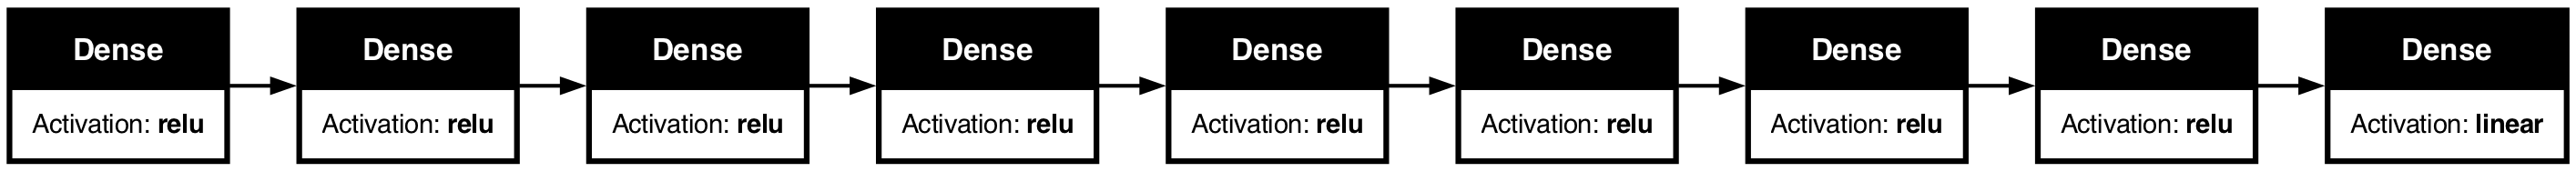

In [6]:
nns = {}
nns['8l'] = build_nn(input_shape=(len(in_cols), ), hidden=[16] * 8)
keras.utils.plot_model(nns['8l'], rankdir='LR', show_layer_activations=True, dpi=150)

And a few less deep network for comparison:

In [7]:
nns['4l'] = build_nn(input_shape=(len(in_cols), ), hidden=[16] * 4)
nns['2l'] = build_nn(input_shape=(len(in_cols), ), hidden=[16] * 2)
nns['1l'] = build_nn(input_shape=(len(in_cols), ), hidden=[16])
nns['0l'] = build_nn(input_shape=(len(in_cols), ), hidden=[])

* `nn1` is shallow and `nn0` is just a linear regressor!

## Training the Networks

**Now, let's prepare the code to train the networks**

In [8]:
def train_nn(nn, X_tr, y_tr, batch_size, epochs, verbose=1):
    nn.compile(loss='mse', optimizer='adam')
    history = nn.fit(X_tr, y_tr, batch_size=batch_size, epochs=epochs, verbose=verbose)
    cols = [k for k in history.history.keys()]
    vals = np.array([history.history[c] for c in cols]).T
    return pd.DataFrame(data=vals, columns=cols)

...And let's train all of them:

In [9]:
histories = []
for l, nn in sorted(nns.items()):
    history = train_nn(nn, X_tr_s, y_tr_s, batch_size=32, epochs=250, verbose=0)
    histories.append(history.rename(columns={c:f'{l} ({c})' for c in history.columns}))
histories = pd.concat(histories, axis=1)

## Training Histories

**Let's have a look at the training history**

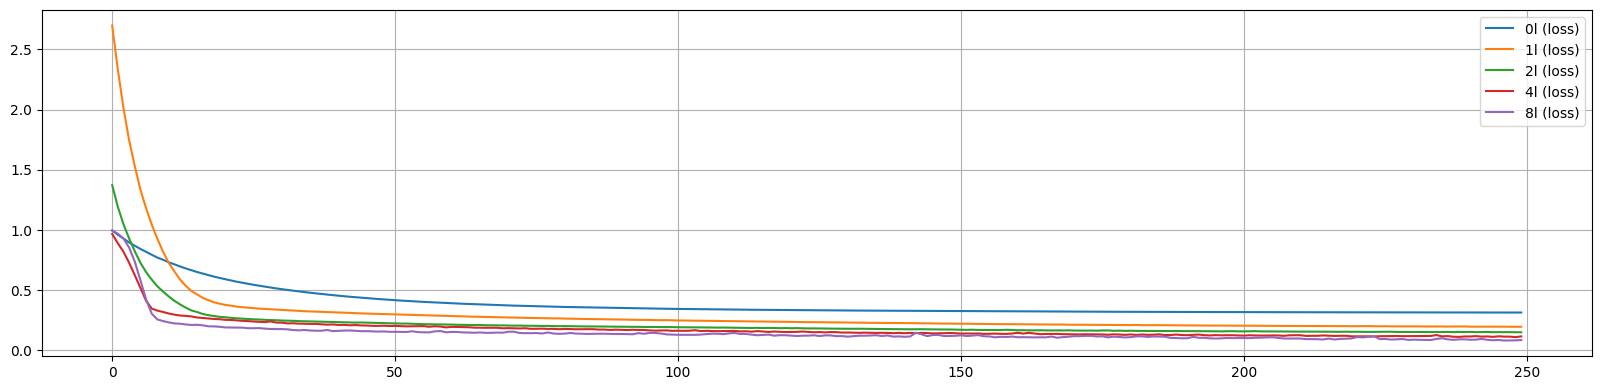

In [10]:
histories.plot(figsize=figsize, grid=':');

* Deeper networks tend to converge faster and to lower loss values
* ...But they also often _start_ from a lower value (right after random initialization)
* This behavior is even now not completely understood

## Evaluation

**Let's have a look at the prediction quality**

In [11]:
pred_tr = {k: y_scaler.inverse_transform(nn.predict(X_tr_s, verbose=0)) for k, nn in sorted(nns.items())}
pred_ts = {k: y_scaler.inverse_transform(nn.predict(X_ts_s, verbose=0)) for k, nn in sorted(nns.items())}

r2_tr = {k: r2_score(y_tr, preds) for k, preds in sorted(pred_tr.items())}
r2_ts = {k: r2_score(y_ts, preds) for k, preds in sorted(pred_ts.items())}

for k in sorted(r2_tr.keys()):
    print(f'r2 score for {k}: {r2_tr[k]:.3f} (training), {r2_ts[k]:.3f} (test)')

r2 score for 0l: 0.689 (training), 0.642 (test)
r2 score for 1l: 0.808 (training), 0.701 (test)
r2 score for 2l: 0.854 (training), 0.691 (test)
r2 score for 4l: 0.891 (training), 0.708 (test)
r2 score for 8l: 0.905 (training), 0.687 (test)


* Adding layers improves the behavior on the training set
* Too many layers may lead to overfitting

**This is actually expected, since deeper networks have _higher variance_**

## Keeping Overfitting at Bay

**How do we reduce overfitting for deep networks?**

* We can of course tune the number of layers (and that's a good solution)
* ...But we loose some of the advantage of depth by doing that

...So what else can we do?

**The first ingredient is _Stochastic_ Gradient Descent**

Let's see what happens if we switch to _classical_ Gradient Descent

In [13]:
nns_gd = {f'{k}l': build_nn(input_shape=(len(in_cols), ), hidden=[16] * k) for k in (8, 4, 2, 1, 0)}
histories_gd = []
for l, nn in sorted(nns_gd.items()):
    history = train_nn(nn, X_tr_s, y_tr_s, batch_size=len(X_tr), epochs=250*8, verbose=0)
    histories_gd.append(history.rename(columns={c:f'{l} ({c})' for c in history.columns}))
histories_gd = pd.concat(histories_gd, axis=1)

* We need to rebuild the networks since keras _does not reset weights_
* Since we are making fewer iterations per epoch, we need to use more epochs

## Training Histories wit Classical GD

**Let's have a look at the new training histories**

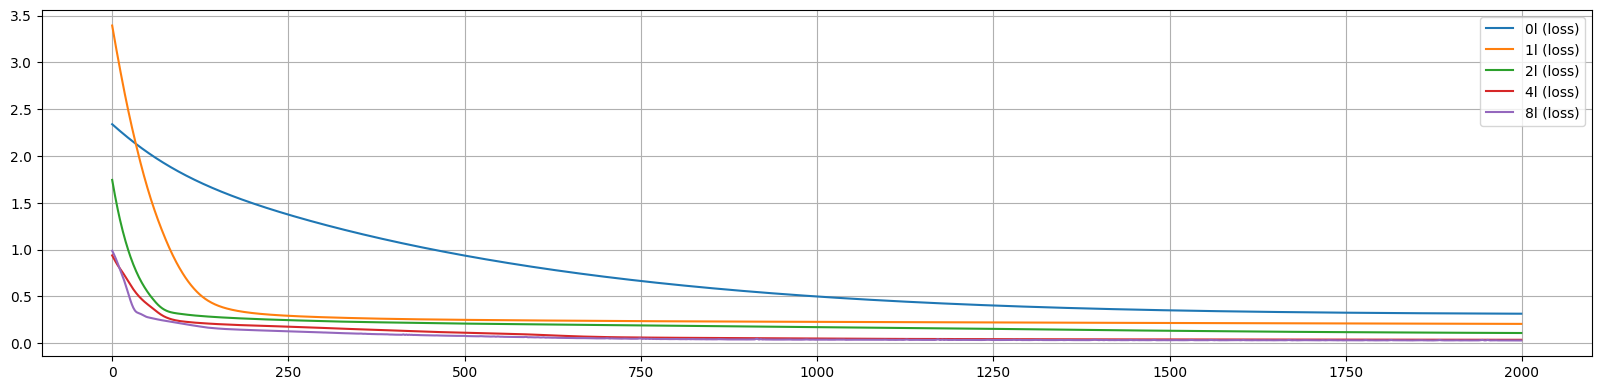

In [14]:
histories_gd.plot(figsize=figsize, grid=':');

* These are not unlike the previous ones
* ...And in all cases we are reasonably close to convergence

## Quality Evaluation with Classical GD

**...But the prediction quality is considerably worse on unseen data!**

In [15]:
pred_tr_gd = {k: y_scaler.inverse_transform(nn.predict(X_tr_s, verbose=0)) for k, nn in sorted(nns_gd.items())}
pred_ts_gd = {k: y_scaler.inverse_transform(nn.predict(X_ts_s, verbose=0)) for k, nn in sorted(nns_gd.items())}
r2_tr_gd = {k: r2_score(y_tr, preds) for k, preds in sorted(pred_tr_gd.items())}
r2_ts_gd = {k: r2_score(y_ts, preds) for k, preds in sorted(pred_ts_gd.items())}
for k in sorted(r2_tr_gd.keys()):
    print(f'r2 score for {k}: {r2_tr_gd[k]:.3f} (training), {r2_ts_gd[k]:.3f} (test)')

r2 score for 0l: 0.684 (training), 0.635 (test)
r2 score for 1l: 0.793 (training), 0.706 (test)
r2 score for 2l: 0.891 (training), 0.699 (test)
r2 score for 4l: 0.963 (training), 0.607 (test)
r2 score for 8l: 0.970 (training), 0.563 (test)


**Deep networks have _many_ local optima**

* Using randomize mini-batches tends to lead the training process
* ...Toward local optima that are _robust to perturbations_

## Early Stopping

**A simple, but effective, option consists in using an _early stopping callback_**

* At training time, we monitor the performance on a validation set
* ...And we stop training if we don't improve enough on that one

In [16]:
def train_nn_es(nn, X_tr, y_tr, batch_size, epochs, verbose=1, patience=30):
    nn.compile(loss='mse', optimizer='adam')
    cb = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)]
    history = nn.fit(X_tr, y_tr, batch_size=batch_size, epochs=epochs, verbose=verbose,
                     callbacks=cb, validation_split=0.2)
    cols = [k for k in history.history.keys()]
    vals = np.array([history.history[c] for c in cols]).T
    return pd.DataFrame(data=vals, columns=cols)

nn8_es = build_nn(input_shape=(len(in_cols), ), hidden=[16] * 8)
history8_es = train_nn_es(nn8_es, X_tr_s, y_tr_s, batch_size=32, epochs=250, verbose=0)

* Typically, the callback waits for a number of epochs (patience)
* If no improvement is achieved within that time frame, training is stopped

## Training History with Early Stopping

**Let's have a look at the training for the 8-level network**

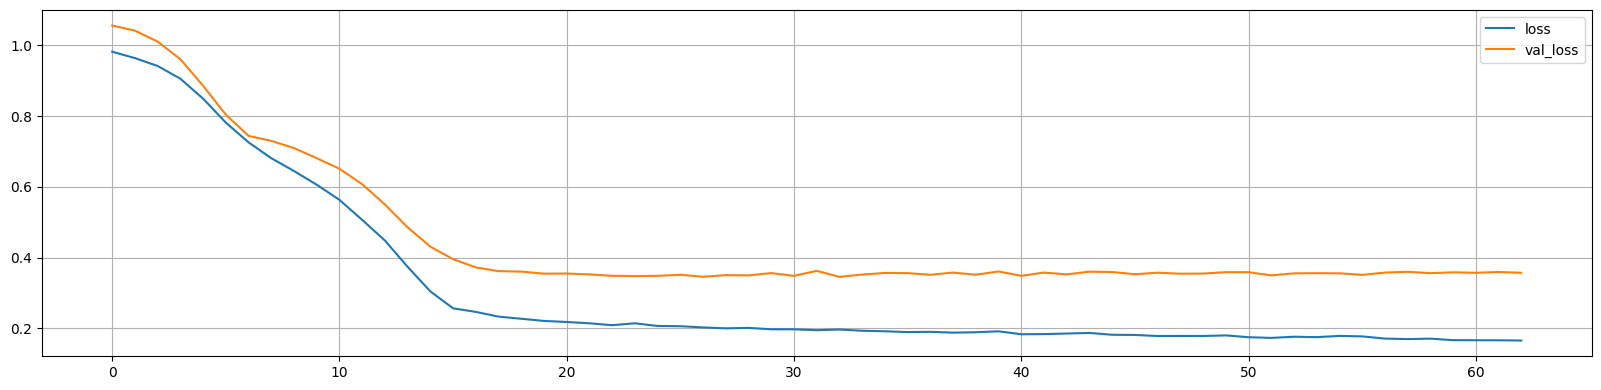

In [17]:
history8_es.plot(figsize=figsize, grid=':');

* We stopped far earlier than the 250 epochs limit

## Prediction Quality with Early Stopping

**Let's check the prediction quality**

In [18]:
pred_tr_nn8_es = y_scaler.inverse_transform(nn8_es.predict(X_tr_s, verbose=0))
pred_ts_nn8_es = y_scaler.inverse_transform(nn8_es.predict(X_ts_s, verbose=0))

r2_tr_nn8_es = r2_score(y_tr, pred_tr_nn8_es)
r2_ts_nn8_es = r2_score(y_ts, pred_ts_nn8_es)

print(f'r2 score for 8l (original): {r2_tr["8l"]:.3f} (training), {r2_ts["8l"]:.3f} (test)')
print(f'r2 score for 8l (es): {r2_tr_nn8_es:.3f} (training), {r2_ts_nn8_es:.3f} (test)')

r2 score for 8l (original): 0.905 (training), 0.687 (test)
r2 score for 8l (es): 0.777 (training), 0.668 (test)


* We are doing worse on the training data
* ...But a bit better on unseen examples!

## Dropout

**Another consists in using the _dropout_ regularization technique**

Dropout consists in removing network nodes at random a training time

* At each gradient descent iteration, nodes are removed with a rate $p$
* Once the iteration is over, everything is restored

**The approach forces the network to develop some redundancy**

In Keras, dropout is implemented as a special layer:

In [20]:
def build_nn_do(input_shape, hidden, rate=0.05):
    mdl = keras.Sequential()
    mdl.add(keras.Input(shape=input_shape))
    for k, h in enumerate(hidden):
        mdl.add(Dense(h, activation='relu')) 
        mdl.add(keras.layers.Dropout(rate))
    mdl.add(Dense(1, activation='linear'))
    return mdl

## Training a Network with Dropout

**Let's train our deeper network with dropout**

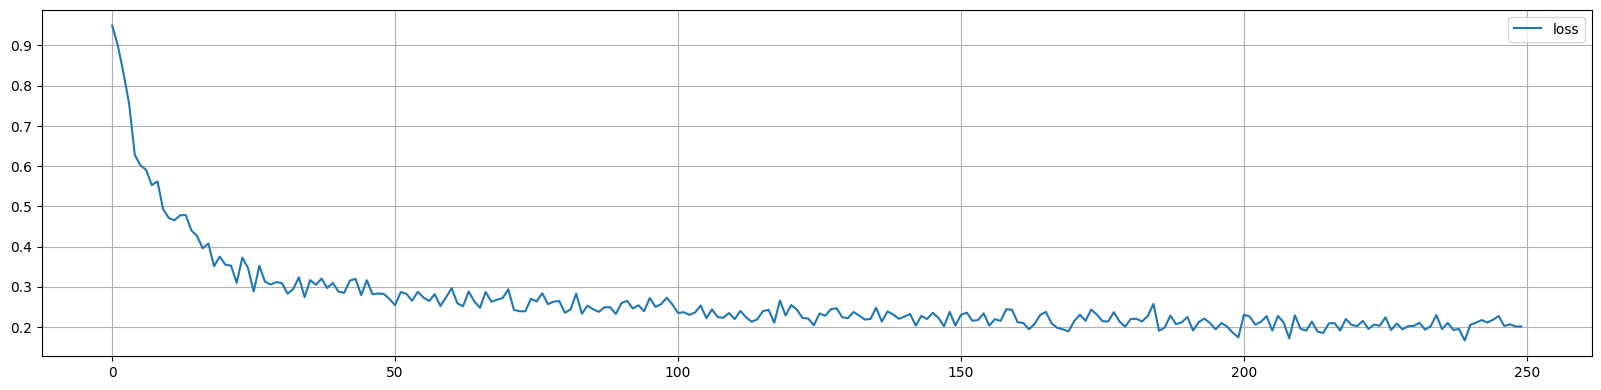

In [21]:
nn8_do = build_nn_do(input_shape=(len(in_cols), ), hidden=[16] * 8)
history8_do = train_nn(nn8_do, X_tr_s, y_tr_s, batch_size=32, epochs=250, verbose=0)
history8_do.plot(figsize=figsize, grid=':');

* We will not use an early stopping callback in this case
* ...So preventing overfitting is totally up to the dropout layer

## Quality Evaluation with Dropout

**Let's check (one last time) the prediction quality**

In [22]:
pred_tr_nn8_do = y_scaler.inverse_transform(nn8_do.predict(X_tr_s, verbose=0))
pred_ts_nn8_do = y_scaler.inverse_transform(nn8_do.predict(X_ts_s, verbose=0))

r2_tr_nn8_do = r2_score(y_tr, pred_tr_nn8_do)
r2_ts_nn8_do = r2_score(y_ts, pred_ts_nn8_do)

print(f'r2 score for 8l (original): {r2_tr["8l"]:.3f} (training), {r2_ts["8l"]:.3f} (test)')
print(f'r2 score for 8l (es): {r2_tr_nn8_es:.3f} (training), {r2_ts_nn8_es:.3f} (test)')
print(f'r2 score for 8l (dropout): {r2_tr_nn8_do:.3f} (training), {r2_ts_nn8_do:.3f} (test)')

r2 score for 8l (original): 0.905 (training), 0.687 (test)
r2 score for 8l (es): 0.777 (training), 0.668 (test)
r2 score for 8l (dropout): 0.821 (training), 0.640 (test)


* Dropout is considerably improving our test score
* Even without any access to unseen examples at training time
* ...Since we are not using a validation set!

## Considerations and Take Home Messages

**Deep network are a powerful tool**

* They dramatically improve the variance of NN models
* ...And allow to tweak the bias/variance trade off by adjusting the depth

**DNs should use ReLUs in the hidden layers**

...Due to the vanishing gradient problem

* Unless of course there a very good reason to do otherwise

**DNs should always be trained with stochastic gradient descent**

...Since that helps reducing overfitting

* There are of course exceptions
* ...But those need to be well motivated

**Other techniques to control overfitting include**

...Early stopping callbacks and dropout